In [1]:
# lad-based-film-transformation

In [2]:
import altair
import cv2
import matplotlib.pylab as plt
import numpy
import pandas
import pathlib
import skimage

In [3]:
def patch_region(n, d):

    ''' Identify patch regions. '''

    regions = list()
    for i in range(n):
        x = (i)*(d['w']+d['d'])+d['x']
        regions.append([x,d['y'],x+d['w'],d['y']+d['h']])
    return regions

def extract_patch(a, i):

    ''' Extract rgb values from image section. '''

    section = i[a[1]:a[3],a[0]:a[2]]
    r = numpy.mean(numpy.ravel(section[:,:,:1]))
    g = numpy.mean(numpy.ravel(section[:,:,1:2]))
    b = numpy.mean(numpy.ravel(section[:,:,2:3]))
    return ([r,g,b])

def patch_values(location, image):

    ''' Reorder rgb values for plotting. '''

    p = [extract_patch(a, image) for a in location]
    p = [[y[x] for y in p] for x in range(len(p[0]))]
    patch_dict = {x:p[n] for n, x in enumerate(['r', 'g', 'b'])}
    return patch_dict

def plot_values(data):

    ''' Plot patch mean values as line graph. '''
    
    data = pandas.melt(pandas.DataFrame(data)).rename(columns={'variable':'channel'})
    data['patch'] = [x%6 for x in range(len(data))]
    chart = altair.Chart(data).mark_line().encode(x='patch:N', y='value',
        color=altair.Color('channel:N', scale=altair.Scale(domain=['r', 'g', 'b'], range=['#c44240', '#40a368', '#2976bb'])))
    display(altair.layer(chart).properties(width=550, height=400, title=''))

def render_image(i):
    print(i.shape)
    plt.figure(figsize=(7.5,7.5))
    plt.imshow(skimage.img_as_float32(i))
    plt.show()  

(3956, 4300, 3)


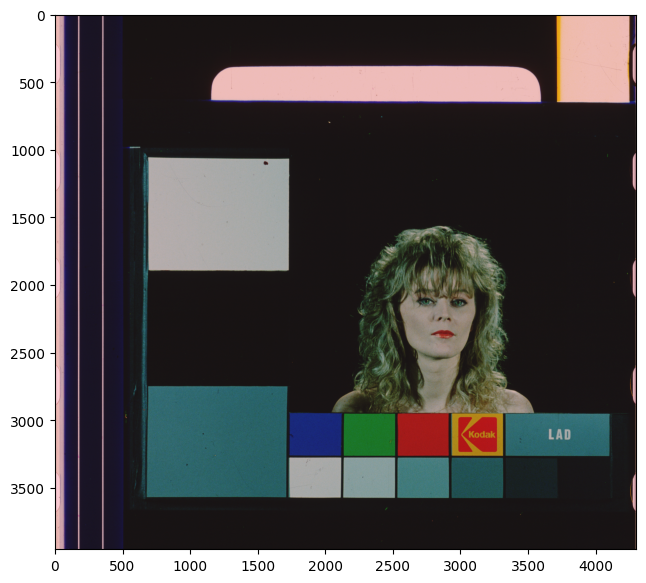

In [4]:
# source frame containing LAD patches

img_path = pathlib.Path.cwd() / '00086400.tif'
img = 1-cv2.cvtColor(cv2.imread(str(img_path), -1), cv2.COLOR_BGR2RGB) 

render_image(img)

(250, 1800, 3)


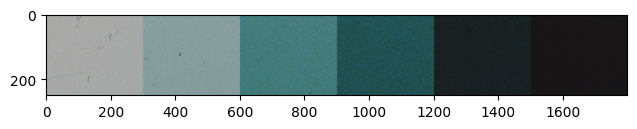

alt.LayerChart(...)

In [5]:
# LAD patches extracted and plotted

region_1 = patch_region(6, {'x':1760, 'y':3300, 'w':300, 'h':250, 'd':100})
region_2 = patch_region(6, {'x':0, 'y':0, 'w':300, 'h':250, 'd':0})

for i in region_1[:1]:
    source_patches = img[i[1]:i[3],i[0]:i[2], :3]
for i in region_1[1:]:
    source_patches = numpy.concatenate((source_patches, img[i[1]:i[3],i[0]:i[2], :3]), axis=1)
  
render_image(source_patches)
source_means = patch_values(region_2, source_patches)
plot_values(source_means)

(250, 1800, 3)


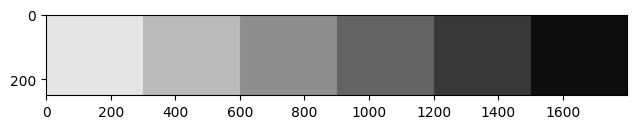

alt.LayerChart(...)

In [6]:
# patch aims, an even distribution of values between DMIN 0.05 and DMAX 0.9

aims = [(x*((0.9-0.05)/5)+0.05)*(2**16) for x in range(6)][::-1]

for x in aims[:1]:
    reference_patches = numpy.zeros((250, 300, 3), numpy.uint16)
    reference_patches[:] = (x, x, x)

for x in aims[1:]:
    add_patch = numpy.zeros((250, 300, 3), numpy.uint16)
    add_patch[:] = (x, x, x)
    reference_patches = numpy.concatenate((reference_patches, add_patch), axis=1)
    
render_image(reference_patches)
reference_means = patch_values(region_2, reference_patches)
plot_values(reference_means)

(250, 1800, 3)


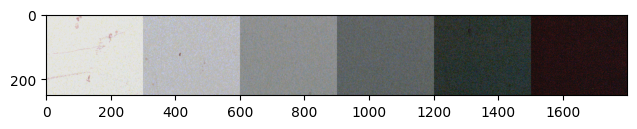

alt.LayerChart(...)

In [7]:
# interpolation of source patches to desired values

transfer_patches = source_patches.copy()
for n, x in enumerate(['r', 'g', 'b']):
    transfer_patches[:,:,n:n+1] = numpy.interp(transfer_patches[:,:,n:n+1], source_means[x][::-1], reference_means[x][::-1])

render_image(transfer_patches)
end_means = patch_values(region_2, transfer_patches)
plot_values(end_means)

(3956, 4300, 3)


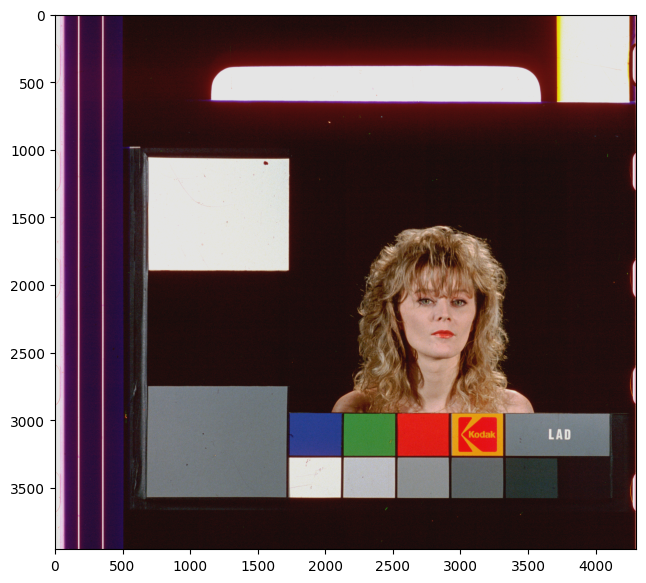

In [8]:
# apply transformation to entire source frame

img_path = pathlib.Path.cwd() / '00086400.tif'
img = 1-cv2.cvtColor(cv2.imread(str(img_path), -1), cv2.COLOR_BGR2RGB) 

for n, x in enumerate(['r', 'g', 'b']):
    img[:,:,n:n+1] = numpy.interp(img[:,:,n:n+1], source_means[x][::-1], reference_means[x][::-1])

render_image(img)